## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [2]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [3]:
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([250., 250., 250., 250., 250., 250., 250., 250.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

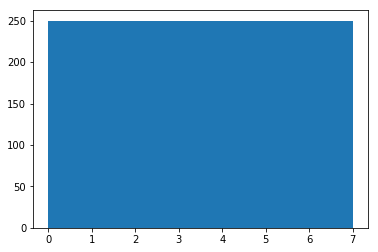

In [4]:
plt.hist(Y_train,bins=8)

(array([50., 50., 50., 50., 50., 50., 50., 50.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

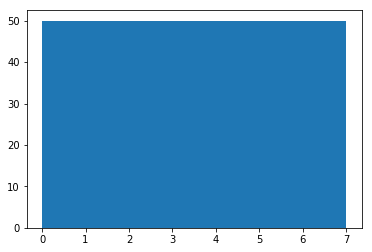

In [5]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

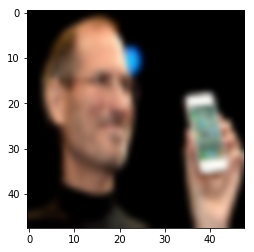

In [6]:
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")

#### Normalization of the training and validationset.

In [7]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

Define the convertToOneHot function and convert the labels into the onehot encoding.

In [8]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [9]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [10]:
print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


### Define the network

In [11]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [12]:
model = Sequential()
name = 'cnn_8_faces'

model.add(Convolution2D(15, (3, 3),padding='same',input_shape=(48,48,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(15, (3,3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(30, (3,3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(30, (3,3),padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 15)        420       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 15)        2040      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 15)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 30)        4080      
_________________________________________________________________
activation_3 (Activation)    (None, 24, 24, 30)        0         
__________

### Running a forward pass of the untrained network

In [14]:
model.evaluate(X_train,Y_train)

2000/2000 [==============================] - 11s 6ms/step


[2.1133472805023192, 0.125]

In [15]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

In [16]:
os.makedirs("Checkpoints/8_faces/model_1_cnn/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/model_1_cnn/8_faces_cnn_"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 5 )

### Training the network

In [17]:
history=model.fit(X_train, Y_train, 
                  batch_size=64, 
                  epochs=80,
                  verbose=1,
                  shuffle=True,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard,checkpointer])

Train on 2000 samples, validate on 400 samples
Epoch 1/80
2000/2000 [==============================] - 25s 13ms/step - loss: 2.3459 - acc: 0.2075 - val_loss: 1.9832 - val_acc: 0.2850
Epoch 2/80
2000/2000 [==============================] - 25s 13ms/step - loss: 1.9319 - acc: 0.3105 - val_loss: 1.8620 - val_acc: 0.3300
Epoch 3/80
2000/2000 [==============================] - 25s 12ms/step - loss: 1.7767 - acc: 0.3715 - val_loss: 1.6506 - val_acc: 0.4050
Epoch 4/80
2000/2000 [==============================] - 25s 12ms/step - loss: 1.6155 - acc: 0.4315 - val_loss: 1.9981 - val_acc: 0.3475
Epoch 5/80
2000/2000 [==============================] - 25s 13ms/step - loss: 1.5299 - acc: 0.4650 - val_loss: 1.5689 - val_acc: 0.4700

Epoch 00005: saving model to Checkpoints/8_faces/model_1_cnn/8_faces_cnn_weights_epoch_005-1.57.hdf5
Epoch 6/80
2000/2000 [==============================] - 25s 12ms/step - loss: 1.4305 - acc: 0.4860 - val_loss: 1.5259 - val_acc: 0.4575
Epoch 7/80
2000/2000 [=============

2000/2000 [==============================] - 25s 13ms/step - loss: 0.3089 - acc: 0.9170 - val_loss: 1.1111 - val_acc: 0.6350
Epoch 54/80
2000/2000 [==============================] - 25s 13ms/step - loss: 0.2858 - acc: 0.9250 - val_loss: 1.0887 - val_acc: 0.6575
Epoch 55/80
2000/2000 [==============================] - 25s 12ms/step - loss: 0.2691 - acc: 0.9310 - val_loss: 0.9884 - val_acc: 0.6775

Epoch 00055: saving model to Checkpoints/8_faces/model_1_cnn/8_faces_cnn_weights_epoch_055-0.99.hdf5
Epoch 56/80
2000/2000 [==============================] - 25s 12ms/step - loss: 0.2677 - acc: 0.9355 - val_loss: 1.1228 - val_acc: 0.6375
Epoch 57/80
2000/2000 [==============================] - 25s 12ms/step - loss: 0.2529 - acc: 0.9420 - val_loss: 1.1273 - val_acc: 0.6225
Epoch 58/80
2000/2000 [==============================] - 25s 13ms/step - loss: 0.2562 - acc: 0.9375 - val_loss: 1.3422 - val_acc: 0.5675
Epoch 59/80
2000/2000 [==============================] - 25s 12ms/step - loss: 0.2609 - 

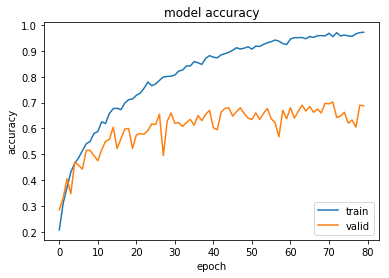

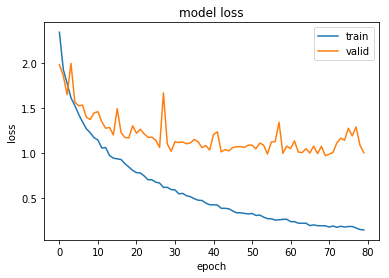

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [19]:
#load a saved model
from keras.models import load_model
model = load_model("Checkpoints/8_faces/model_1_cnn/8_faces_cnn_weights_epoch_070-0.97.hdf5")

In [20]:
preds=model.predict(X_valid)

In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[39  1  0  1  0  2  7  0]
 [ 3 19  2  8  1  9  1  7]
 [ 4  0 38  0  1  0  0  7]
 [ 1  3  3 37  0  3  2  1]
 [ 0  2  2  1 41  0  0  4]
 [ 0  3  1  2  1 36  5  2]
 [ 6  0  0  2  2  5 33  2]
 [ 2  2  2  1  3  0  4 36]]
Acc =  0.6975


### Evaluation on the test set

In [22]:
# Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1",
    "8_faces_test.hdf5")

In [23]:
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


In [24]:
X_test = (X_test - X_mean ) / (X_std + 0.0001)

In [25]:
preds_test=model.predict(X_test)

In [32]:
print(confusion_matrix(Y_test[:],np.argmax(preds_test,axis=1)))
print("Acc = " ,np.sum(Y_test[:]==np.argmax(preds_test,axis=1))/len(preds_test))

[[36  2  2  0  0  0  7  3]
 [ 2 15  4  4 10  9  2  4]
 [ 1  1 43  1  0  3  0  1]
 [ 0  0  3 36  1  3  2  5]
 [ 0  4  0  0 40  1  1  4]
 [ 1  5  2  1  0 37  1  3]
 [ 1  0  3  3  1  2 37  3]
 [ 0  2  6  2  2  1  2 35]]
Acc =  0.6975
